## Домашнее задание №2. Градиентный спуск
### Кирбаба Денис, группа R3338

Подключим Google Drive к проекту

In [1]:
# This mounts Google Drive to the Colab VM
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'optimization-methods/src/'

# Ensure that Python interpreter of the Colab VM can load python files from within it
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import outer libraries and packages
import numpy as np
import random

# import inner modules
from oracles import *
from methods import *
from plot_trajectory_2d import *

Настройки для графиков

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,9)
import matplotlib.patches as mpatches

# Задание 1. Методы и оракулы

Реализуем недостающие методы .func и .grad в оракуле QuadraticOracle в модуле oracles.py

Здесь я предоставил закомментированный код для наглядности, выполнять его не нужно, так как это собьет работу следующих блоков (так как я делаю import файлов с этим кодом из Google Drive).

In [7]:
# class QuadraticOracle(BaseSmoothOracle):
#     """
#     Oracle for quadratic function:
#        func(x) = 1/2 x^TAx - b^Tx.
#     """
    
#     def __init__(self, A, b):
#         if not scipy.sparse.isspmatrix_dia(A) and not np.allclose(A, A.T):
#             raise ValueError('A should be a symmetric matrix.')
#         self.A = A
#         self.b = np.squeeze(b)

#     def func(self, x):
#         x = np.squeeze(x)
#         return 0.5 * np.dot(np.dot(x, self.A), np.transpose(x)) - np.dot(self.b, np.transpose(x))

#     def grad(self, x):
#         x = np.squeeze(x)
#         return np.squeeze(np.dot(self.A, np.transpose(x)) - np.transpose(self.b))

Реализуем недостающие методы .func и .grad в оракуле LogRegL2Oracle в модуле oracles.py

Вначале я реализовал функцию, которая не является оптимальной (выполняет суммирование по циклу), а затем улучшенный вариант с матричными вычислениями для существенно быстрой работы

In [8]:
# def func_semi_vectorized(self, x):
#     res = 0
#     for i in range(np.max(self.b.shape)):
#         res += np.log(1 + np.exp(-self.b[0][i] * self.matvec_Ax(x)[i]))
#     return res / np.max(self.b.shape) + self.regcoef * np.linalg.norm(x)

In [9]:
# def func(self, x):
#     x = np.squeeze(x)
#     return np.average(np.log(1 + np.exp(-np.multiply(self.b, np.transpose(self.matvec_Ax(x)))))) + np.linalg.norm(x) * self.regcoef

Также для создания объектов логистической регрессии был реализован метод create_log_reg_oracle()

In [10]:
# def create_log_reg_oracle(A, b, regcoef):
#     """
#     Auxiliary function for creating logistic regression oracles.
#         `oracle_type` must be either 'usual' or 'optimized'
#     """
#     matvec_Ax = lambda x: np.dot(A, np.transpose(x))
#     matvec_ATx = lambda x: np.dot(np.transpose(A), x)

#     def matmat_ATsA(s):
#         return np.dot(np.dot(np.transpose(A), np.diag(s)), A)

#     b = np.squeeze(b)

#     return LogRegL2Oracle(A, b, regcoef, matvec_Ax, matvec_ATx, matmat_ATsA)

Теперь посчитаем градиент логистической функции. 
Результатом будет следующая функция:  
f'_xk = -1/m * sum_i(b_i * A_i_k * (1 - 1 / (1 + exp(-b_i * A_i * x))) + regcoef * 2 * x_k)

In [11]:
# def grad(self, x):
#     x = np.squeeze(x)
#     grad = np.zeros_like(x)
#     for i in range(np.max(x.shape)):
#         grad[i] = np.average(np.multiply(np.multiply(self.b, np.transpose(self.A[:, i])), 1 - 1 / (1 + np.exp(-np.multiply(self.b, np.transpose(self.matvec_Ax(x)))))))
#     grad = -grad + self.regcoef * 2 * x

#     return grad

Реализуем методы одномерного поиска, соответствующие правилу Армихо и Вульфа.

In [12]:
# def line_search(self, oracle, x_k, d_k, previous_alpha=None):
#     """
#     Finds the step size alpha for a given starting point x_k
#     and for a given search direction d_k that satisfies necessary
#     conditions for phi(alpha) = oracle.func(x_k + alpha * d_k).

#     Parameters
#     ----------
#     oracle : BaseSmoothOracle-descendant object
#         Oracle with .func_directional() and .grad_directional() methods implemented for computing
#         function values and its directional derivatives.
#     x_k : np.array
#         Starting point
#     d_k : np.array
#         Search direction
#     previous_alpha : float or None
#         Starting point to use instead of self.alpha_0 to keep the progress from
#             previous steps. If None, self.alpha_0, is used as a starting point.

#     Returns
#     -------
#     alpha : float or None if failure
#         Chosen step size
#     """
#     if self._method == 'Constant':
#         return self.c
#     elif self._method == 'Armijo':
#         # Setting alpha
#         alpha = self.alpha_0
#         if previous_alpha is not None:
#             alpha = previous_alpha * 2  # adaptive term

#         # Calculate phi-values
#         phi0 = oracle.func_directional(x_k, d_k, 0)
#         derphi0 = oracle.grad_directional(x_k, d_k, 0)

#         # Check condition and change alpha
#         while oracle.func_directional(x_k, d_k, alpha) > phi0 + self.c1 * alpha * derphi0:
#             alpha /= 2
#         return alpha

#     elif self._method == 'Wolfe':
#         # Create functions, that calculate phi and derphi
#         # to pass them to the wolfe scipy function
#         def phi(x):
#             return oracle.func_directional(x_k, d_k, x)

#         def derphi(x):
#             return oracle.grad_directional(x_k, d_k, x)

#         # Execute wolfe function
#         alpha, *_ = scalar_search_wolfe2(phi=phi, derphi=derphi, c1=self.c1, c2=self.c2)

#         # Check if alpha is found, otherwise find alpha using Armijo method
#         if alpha is not None:
#             return alpha
#         else:
#             return LineSearchTool(method='Armijo', c1=self.c1, alpha_0=self.alpha_0).line_search(oracle, x_k, d_k,
#                                                                                                     previous_alpha)

Реализуем метод градиентного спуска.

In [13]:
# class GradientDescent(object):
#     """
#     Gradient descent optimization algorithm.
    
#     oracle : BaseSmoothOracle-descendant object
#         Oracle with .func() and .grad() methods implemented for computing
#         function value and its gradient respectively.
#     x_0 : np.array
#         Starting point for optimization algorithm
#     tolerance : float
#         Epsilon value for stopping criterion.
#     line_search_options : dict, LineSearchTool or None
#         Dictionary with line search options. See LineSearchTool class for details.
#     """

#     def __init__(self, oracle, x_0, tolerance=1e-10, line_search_options=None):
#         self.oracle = oracle
#         x_0 = np.squeeze(x_0)
#         self.x_0 = x_0.copy()
#         self.tolerance = tolerance
#         self.line_search_tool = get_line_search_tool(line_search_options)
#         self.hist = defaultdict(list)

#     def run(self, max_iter=100):
#         """
#         Runs gradient descent for max_iter iterations or until stopping 
#         criteria is satisfied, starting from point x_0. Saves function values 
#         and time in self.hist
        
#         self.hist : dictionary of lists
#         Dictionary containing the progress information
#         Dictionary has to be organized as follows:
#             - self.hist['time'] : list of floats, containing time in seconds passed from the start of the method
#             - self.hist['func'] : list of function values f(x_k) on every step of the algorithm
#             - self.hist['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
#             - self.hist['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2
#             - self.hist['x_star']: np.array containing x at last iteration

#         """
#         # Set the changeable variables
#         x_cur = np.copy(self.x_0)
#         alpha_cur = None

#         # Set the stop-condition
#         norm_0 = np.power(np.linalg.norm(self.oracle.grad(self.x_0)), 2)
#         stop_condition = self.tolerance * norm_0

#         # Save starting time
#         start = datetime.now()

#         # Start main cycle
#         for i in range(max_iter):
#             # Calculate current direction (grad_cur) and step (alpha_cur)
#             d_cur = -self.oracle.grad(x_cur)
#             alpha_cur = self.line_search_tool.line_search(self.oracle, x_cur, d_cur,
#                                                           alpha_cur if alpha_cur is not None else None)

#             # Calculate for stop-condition checking
#             norm_cur = np.linalg.norm(-d_cur)

#             # Write the history
#             if x_cur.size <= 2:
#                 self.hist['x'].append(np.copy(x_cur))
#             self.hist['time'].append((datetime.now() - start).total_seconds())
#             self.hist['func'].append(self.oracle.func(x_cur))
#             self.hist['grad_norm'].append(np.copy(norm_cur).item(0))

#             # Check stop-condition
#             if np.power(norm_cur, 2) <= stop_condition:
#                 self.hist['x_star'].append(np.copy(x_cur))
#                 return self.hist
#             else:
#                 x_cur += alpha_cur * d_cur

#         # If here, then number of iterations exceeded
#         # We need to add last state to the history
#         if x_cur.size <= 2:
#             self.hist['x'].append(np.copy(x_cur))
#         self.hist['time'].append((datetime.now() - start).total_seconds())
#         self.hist['func'].append(self.oracle.func(x_cur))
#         self.hist['grad_norm'].append(np.copy(norm_cur).item(0))
#         self.hist['x_star'].append(np.copy(x_cur))

#         return self.hist


# Задание 2. Траектория градиентного спуска на квадратичной функции

Зададим три квадратичные функции.   

In [11]:
def find_k(A):
    eig_v, _ = np.linalg.eig(A)
    return max(eig_v)/min(eig_v)

In [12]:
A_1 = np.array([[0.414, 0.4], 
                [0.4, 17.87]])
print(find_k(A_1))

A_2 = np.array([[75.04, 3.41],
                [3.41, 31.21]])
print(find_k(A_2))

A_3 = np.array([[8.134, 14.2],
                [14.2, 84.146]])
print(find_k(A_3))

b_1 = np.array([[13], [14]], dtype=np.float64)
b_2 = np.array([[1], [14]], dtype=np.float64)
b_3 = np.array([[91], [54]], dtype=np.float64)

x_0_1 = np.array([10.44, 4.14])
x_0_2 = np.array([4.14, -6.24])
x_0_3 = np.array([28.49, 3.14])

44.16364354865404
2.433368311196728
15.573600576844237


Число обусловленности у первой квадратичной функции = 44.16.  
Число обусловленности у второй квадратичной функции = 2.433.  
Число обусловленности у третьей квадратичной функции = 15.574. 

In [13]:
quad_oracle_1 = QuadraticOracle(A_1, b_1)
quad_oracle_2 = QuadraticOracle(A_2, b_2)
quad_oracle_3 = QuadraticOracle(A_3, b_3)

Запустим на них градиентные методы с различными стратегиями выбора шага: константный метод, метод Армихо, метод Вульфа.  
## Константный метод:  

In [14]:
gd_1 = GradientDescent(quad_oracle_1, x_0_1, 1e-5, line_search_options=dict(method='Constant', c=0.07))
gd_2 = GradientDescent(quad_oracle_2, x_0_2, 1e-10, line_search_options=dict(method='Constant', c=0.01))
gd_3 = GradientDescent(quad_oracle_3, x_0_3, 1e-10, line_search_options=dict(method='Constant', c=0.01))

In [15]:
history_1 = gd_1.run(max_iter=200)
history_2 = gd_2.run(max_iter=200)
history_3 = gd_3.run(max_iter=200)

Теперь отобразим линии уровня и траектории работы градиентного спуска для трех уравнений

### Первое уравнение, число обусловленности =44.16

/content/drive/My Drive/optimization-methods/src/plot_trajectory_2d.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0)


Text(0, 0.5, 'x_2')

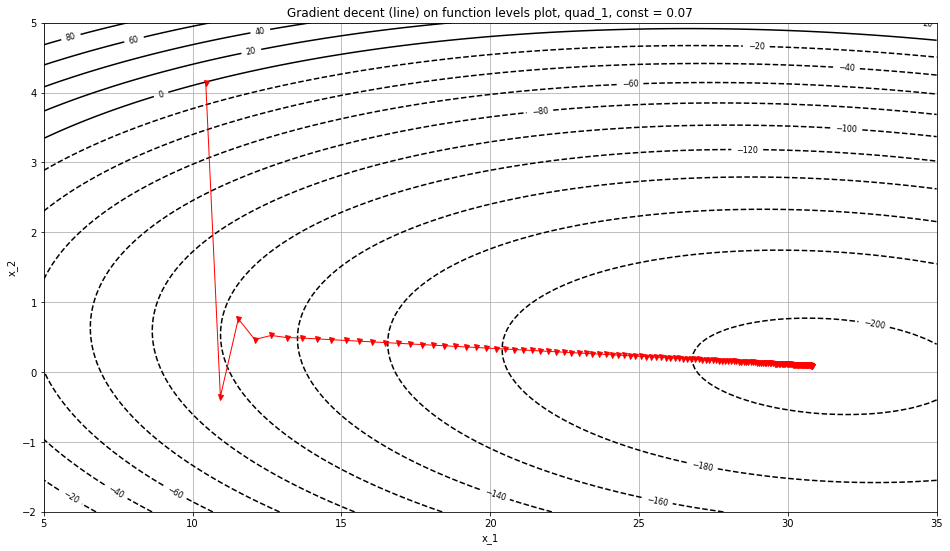

In [19]:
plot_levels(quad_oracle_1.func, xrange=[5, 35], yrange=[-2, 5], levels = np.arange(-200, 100, 20))
plot_trajectory(quad_oracle_1.func, history_1['x'])
plt.title("Gradient decent (line) on function levels plot, quad_1, const = 0.07")
plt.xlabel("x_1")
plt.ylabel("x_2")

In [20]:
# some data about method work
print("Final point: x_1 = %f, x_2 = %f, y = %f" % (history_1['x_star'][0][0], history_1['x_star'][0][0], history_1['func'][-1]))
print("Number of iterations: %d" % (len(history_1['time']) - 1))
print("Execution time: %f sec" % (history_1['time'][-1]))
print("Norm of last d_k: %f" % (history_1['grad_norm'][-1]))


Final point: x_1 = 30.822069, x_2 = 30.822069, y = -204.115052
Number of iterations: 130
Execution time: 0.014157 sec
Norm of last d_k: 0.202206


Как видно, метод градиентного спуска нашел минимум функции за 130 итераций (остановка случилась так как норма градиента стала мала). 
В данном случае пришлось подбирать параметр *c* вручную.

### Второе уравнение, число обусловленности 2.233

Text(0, 0.5, 'x_2')

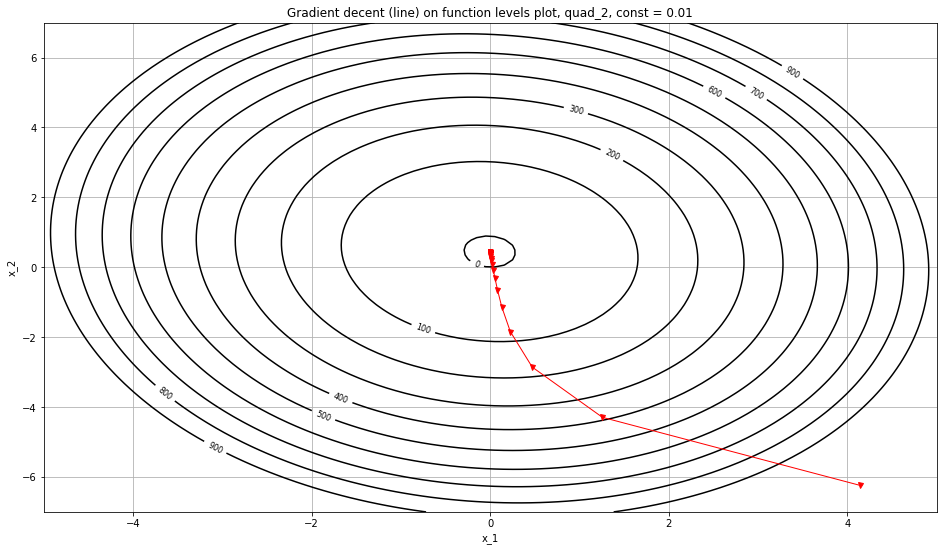

In [21]:
plot_levels(quad_oracle_2.func, xrange=[-5, 5], yrange=[-7, 7], levels = np.arange(0, 1000, 100))
plot_trajectory(quad_oracle_2.func, history_2['x'])
plt.title("Gradient decent (line) on function levels plot, quad_2, const = 0.01")
plt.xlabel("x_1")
plt.ylabel("x_2")

In [22]:
# some data about method work
print("Final point: x_1 = %f, x_2 = %f, y = %f" % (history_2['x_star'][0][0], history_2['x_star'][0][0], history_2['func'][-1]))
print("Number of iterations: %d" % (len(history_2['time']) - 1))
print("Execution time: %f sec" % (history_2['time'][-1]))
print("Norm of last d_k: %f" % (history_2['grad_norm'][-1]))


Final point: x_1 = -0.007085, x_2 = -0.007085, y = -3.141897
Number of iterations: 30
Execution time: 0.001868 sec
Norm of last d_k: 0.003241


На данной функции метод сработал намного быстрее (хотя условие остановки сильнее), найдя минимум за 30 операций.

### Третье уравнение, число обусловленности 15.574

Text(0, 0.5, 'x_2')

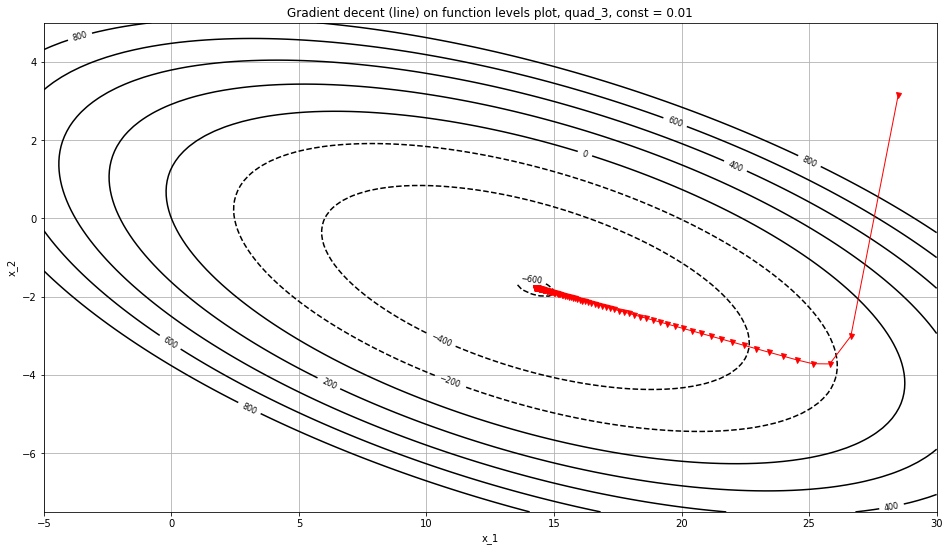

In [23]:
plot_levels(quad_oracle_3.func, xrange=[-5, 30], yrange=[-7.5, 5], levels = np.arange(-1000, 1000, 200))
plot_trajectory(quad_oracle_3.func, history_3['x'])
plt.title("Gradient decent (line) on function levels plot, quad_3, const = 0.01")
plt.xlabel("x_1")
plt.ylabel("x_2")

In [24]:
# some data about method work
print("Final point: x_1 = %f, x_2 = %f, y = %f" % (history_3['x_star'][0][0], history_3['x_star'][0][0], history_3['func'][-1]))
print("Number of iterations: %d" % (len(history_3['time']) - 1))
print("Execution time: %f sec" % (history_3['time'][-1]))
print("Norm of last d_k: %f" % (history_3['grad_norm'][-1]))


Final point: x_1 = 14.272894, x_2 = 14.272894, y = -601.667231
Number of iterations: 164
Execution time: 0.007924 sec
Norm of last d_k: 0.006070


Метод нашел минимум за 164 итерации - результат удовлетворительный.

Теперь рассмотрим метод Вульфа при тех же уравнениях и начальных условиях  
## Метод Вульфа

In [16]:
# c1 in (0, 0.5), c2 in (c1, 1)
gd_1 = GradientDescent(quad_oracle_1, x_0_1, 1e-5, line_search_options=dict(method='Wolfe', c1=1e-4, c2=0.9))
gd_2 = GradientDescent(quad_oracle_2, x_0_2, 1e-10, line_search_options=dict(method='Wolfe', c1=1e-4, c2=0.9))
gd_3 = GradientDescent(quad_oracle_3, x_0_3, 1e-10, line_search_options=dict(method='Wolfe', c1=1e-4, c2=0.9))

In [17]:
history_1 = gd_1.run(max_iter=200)
history_2 = gd_2.run(max_iter=200)
history_3 = gd_3.run(max_iter=200)

### Первое уравнение, число обусловленности = 44.16

Text(0, 0.5, 'x_2')

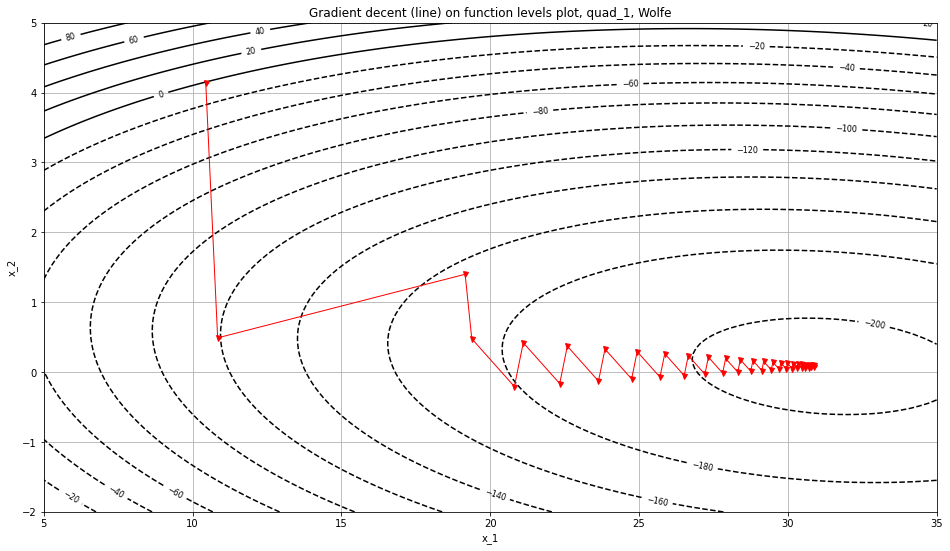

In [27]:
plot_levels(quad_oracle_1.func, xrange=[5, 35], yrange=[-2, 5], levels = np.arange(-200, 100, 20))
plot_trajectory(quad_oracle_1.func, history_1['x'])
plt.title("Gradient decent (line) on function levels plot, quad_1, Wolfe")
plt.xlabel("x_1")
plt.ylabel("x_2")

In [28]:
# some data about method work
print("Final point: x_1 = %f, x_2 = %f, y = %f" % (history_1['x_star'][0][0], history_1['x_star'][0][0], history_1['func'][-1]))
print("Number of iterations: %d" % (len(history_1['time']) - 1))
print("Execution time: %f sec" % (history_1['time'][-1]))
print("Norm of last d_k: %f" % (history_1['grad_norm'][-1]))


Final point: x_1 = 30.875605, x_2 = 30.875605, y = -204.125097
Number of iterations: 45
Execution time: 0.013807 sec
Norm of last d_k: 0.197975


Как видим, количество итераций сократилось втрое по сравнению с константным методом. Видно по траектории, что можно её немного улучшить (подобрав наиболее подходящие константы).

### Второе уравнение, число обусловленности 2.233

Text(0, 0.5, 'x_2')

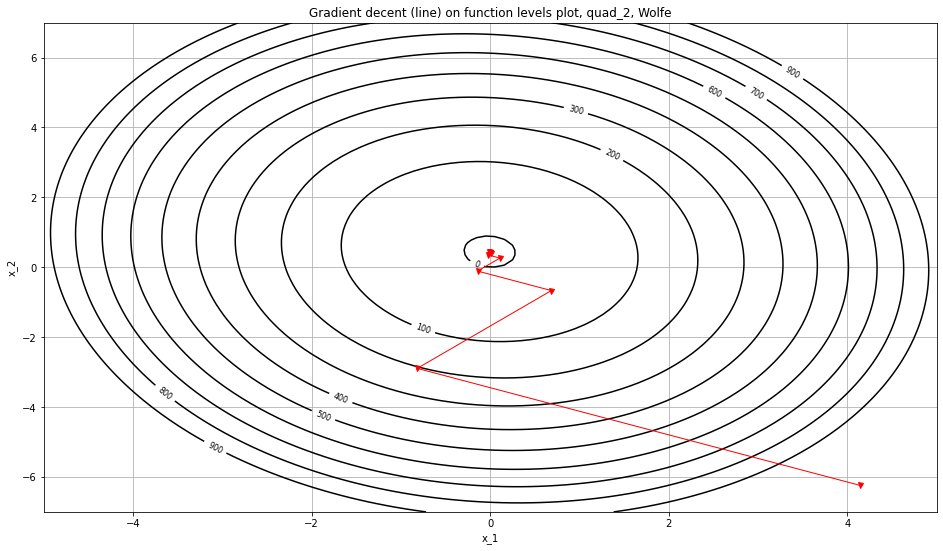

In [29]:
plot_levels(quad_oracle_2.func, xrange=[-5, 5], yrange=[-7, 7], levels = np.arange(0, 1000, 100))
plot_trajectory(quad_oracle_2.func, history_2['x'])
plt.title("Gradient decent (line) on function levels plot, quad_2, Wolfe")
plt.xlabel("x_1")
plt.ylabel("x_2")

In [30]:
# some data about method work
print("Final point: x_1 = %f, x_2 = %f, y = %f" % (history_2['x_star'][0][0], history_2['x_star'][0][0], history_2['func'][-1]))
print("Number of iterations: %d" % (len(history_2['time']) - 1))
print("Execution time: %f sec" % (history_2['time'][-1]))
print("Norm of last d_k: %f" % (history_2['grad_norm'][-1]))


Final point: x_1 = -0.007093, x_2 = -0.007093, y = -3.141898
Number of iterations: 11
Execution time: 0.003552 sec
Norm of last d_k: 0.000802


Тут опять же можем заметить, что число операций сократилось примерно втрое по сравнению с константным методом. 

### Третье уравнение, число обусловленности 15.574

Text(0, 0.5, 'x_2')

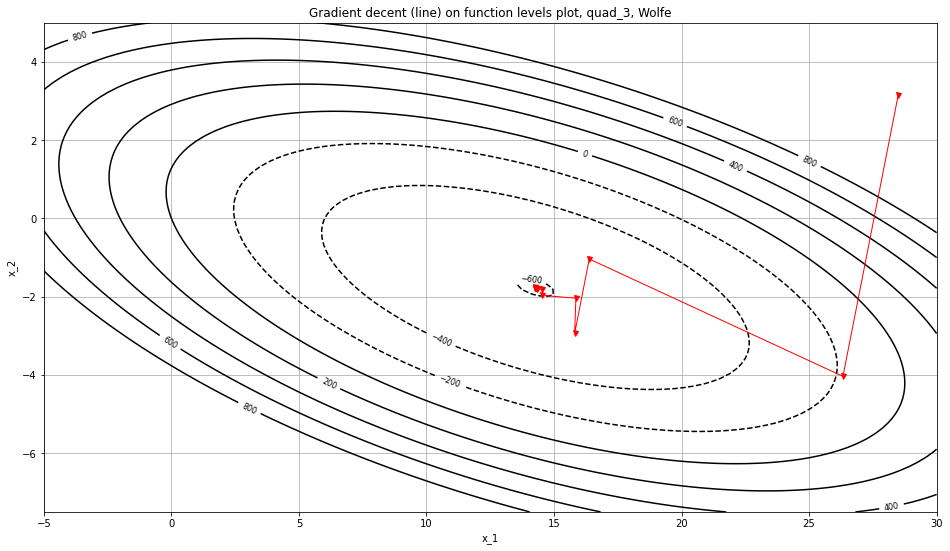

In [31]:
plot_levels(quad_oracle_3.func, xrange=[-5, 30], yrange=[-7.5, 5], levels = np.arange(-1000, 1000, 200))
plot_trajectory(quad_oracle_3.func, history_3['x'])
plt.title("Gradient decent (line) on function levels plot, quad_3, Wolfe")
plt.xlabel("x_1")
plt.ylabel("x_2")

In [32]:
# some data about method work
print("Final point: x_1 = %f, x_2 = %f, y = %f" % (history_3['x_star'][0][0], history_3['x_star'][0][0], history_3['func'][-1]))
print("Number of iterations: %d" % (len(history_3['time']) - 1))
print("Execution time: %f sec" % (history_3['time'][-1]))
print("Norm of last d_k: %f" % (history_3['grad_norm'][-1]))


Final point: x_1 = 14.272062, x_2 = 14.272062, y = -601.667234
Number of iterations: 14
Execution time: 0.003397 sec
Norm of last d_k: 0.001372


В третьем уравнении наблюдаем существенное преимущество метода Вульфа над константным (число операций изменилось с 140 до 14).

Теперь применим оставшийся метод Армихо.

## Метод Армихо

In [33]:
# c1 in (0, 0.5), alpha_0 = 1
gd_1 = GradientDescent(quad_oracle_1, x_0_1, 1e-5, line_search_options=dict(method='Armijo', c1=1e-4, alpha_0=1.0))
gd_2 = GradientDescent(quad_oracle_2, x_0_2, 1e-10, line_search_options=dict(method='Armijo', c1=1e-4, alpha_0=1.0))
gd_3 = GradientDescent(quad_oracle_3, x_0_3, 1e-10, line_search_options=dict(method='Armijo', c1=1e-4, alpha_0=1.0))

In [34]:
history_1 = gd_1.run(max_iter=200)
history_2 = gd_2.run(max_iter=200)
history_3 = gd_3.run(max_iter=200)

### Первое уравнение, число обусловленности 44.16

Text(0, 0.5, 'x_2')

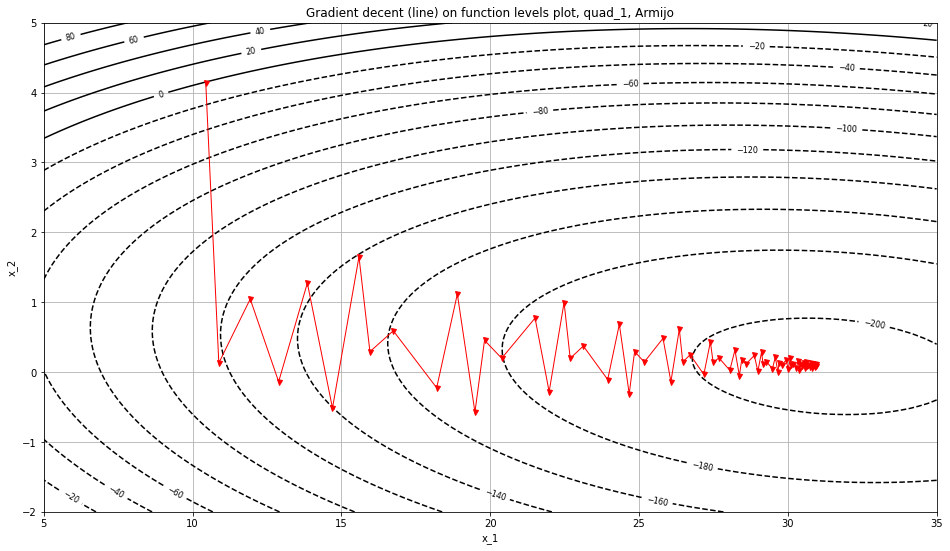

In [35]:
plot_levels(quad_oracle_1.func, xrange=[5, 35], yrange=[-2, 5], levels = np.arange(-200, 100, 20))
plot_trajectory(quad_oracle_1.func, history_1['x'])
plt.title("Gradient decent (line) on function levels plot, quad_1, Armijo")
plt.xlabel("x_1")
plt.ylabel("x_2")

In [36]:
# some data about method work
print("Final point: x_1 = %f, x_2 = %f, y = %f" % (history_1['x_star'][0][0], history_1['x_star'][0][0], history_1['func'][-1]))
print("Number of iterations: %d" % (len(history_1['time']) - 1))
print("Execution time: %f sec" % (history_1['time'][-1]))
print("Norm of last d_k: %f" % (history_1['grad_norm'][-1]))


Final point: x_1 = 30.939127, x_2 = 30.939127, y = -204.135845
Number of iterations: 71
Execution time: 0.007832 sec
Norm of last d_k: 0.168147


С данным методом, градиентный спуск нашел минимум на 71 итерации

### Второе уравнение, число обусловленности 2.233

Text(0, 0.5, 'x_2')

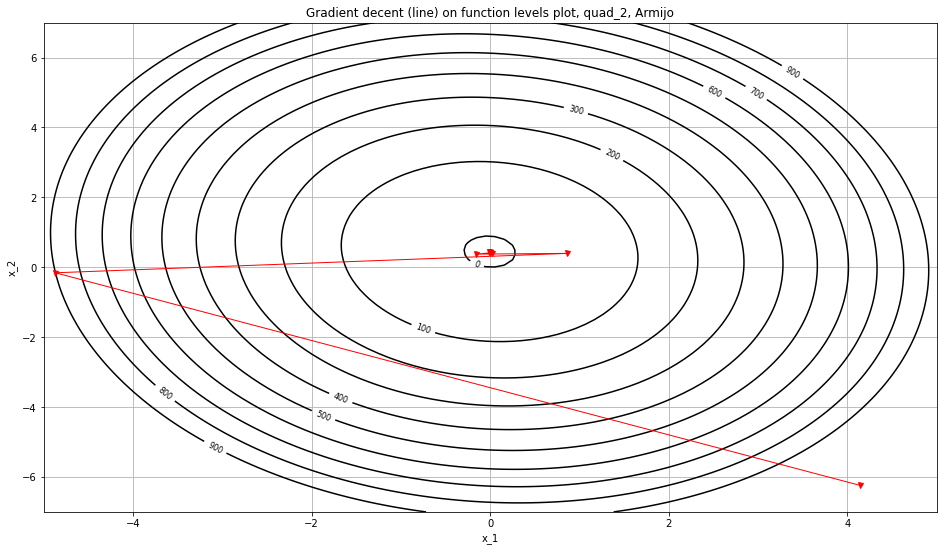

In [37]:
plot_levels(quad_oracle_2.func, xrange=[-5, 5], yrange=[-7, 7], levels = np.arange(0, 1000, 100))
plot_trajectory(quad_oracle_2.func, history_2['x'])
plt.title("Gradient decent (line) on function levels plot, quad_2, Armijo")
plt.xlabel("x_1")
plt.ylabel("x_2")

In [38]:
# some data about method work
print("Final point: x_1 = %f, x_2 = %f, y = %f" % (history_2['x_star'][0][0], history_2['x_star'][0][0], history_2['func'][-1]))
print("Number of iterations: %d" % (len(history_2['time']) - 1))
print("Execution time: %f sec" % (history_2['time'][-1]))
print("Norm of last d_k: %f" % (history_2['grad_norm'][-1]))


Final point: x_1 = -0.007102, x_2 = -0.007102, y = -3.141898
Number of iterations: 11
Execution time: 0.001078 sec
Norm of last d_k: 0.000641


С данным методом выбора коэффициента, градиентный спуск нашел минимум на 11 итерации. Стоит отметить довольно интересную траекторию поиска в начале

### Третье уравнение, число обусловленности 15.574

Text(0, 0.5, 'x_2')

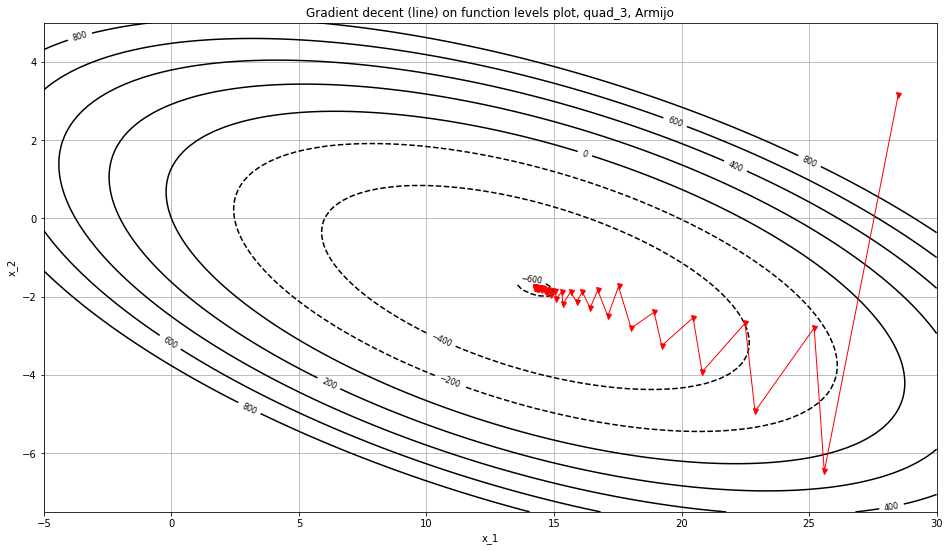

In [39]:
plot_levels(quad_oracle_3.func, xrange=[-5, 30], yrange=[-7.5, 5], levels = np.arange(-1000, 1000, 200))
plot_trajectory(quad_oracle_3.func, history_3['x'])
plt.title("Gradient decent (line) on function levels plot, quad_3, Armijo")
plt.xlabel("x_1")
plt.ylabel("x_2")

In [40]:
# some data about method work
print("Final point: x_1 = %f, x_2 = %f, y = %f" % (history_3['x_star'][0][0], history_3['x_star'][0][0], history_3['func'][-1]))
print("Number of iterations: %d" % (len(history_3['time']) - 1))
print("Execution time: %f sec" % (history_3['time'][-1]))
print("Norm of last d_k: %f" % (history_3['grad_norm'][-1]))


Final point: x_1 = 14.272478, x_2 = 14.272478, y = -601.667233
Number of iterations: 68
Execution time: 0.005731 sec
Norm of last d_k: 0.004746


Данный вариант градиентного спуска нашел минимум при 68 итерациях

## Выводы
При использовании константного метода требуется дополнительно подбирать коэффициент *c*, так как существует довольно много значений, при которых будет происходить перескакивание между точкой минимума (в таких случаях нужно уменьшать *c*, в теории управления это называется перерегулированием).  
Вообще говоря, константный метод выполняет больше всех итераций (хотя и сложность действий на каждой итерации у него меньше) и по временным затратам константный метод примерно равен методу Армихо.  
Что касается точности, то константный метод при постоянном значении *c* не сможет в некоторых случаях "подобраться" к минимуму с требуемой нами точностью, чего не наблюдается в остальных методах (логично, так как там переменная *c*).  
Также имеет смысл следующая закономерность: при уменьшении числоа обусловленности все методы градиентного спуска затрачивают меньше действий/времени на поиск минимума.  
Зависимость методов от начальной точки следующая: чем ближе начальная точка к точке минимума, тем быстрее работает алгоритм (так как мы тут рассматривали уни-модальную функцию, то других зависимостей не было выявлено).  


# Задание 3. Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

Здесь необходимо исследовать зависимость числа обусловленности k и размерности пространства n.  
В данном задании будем использовать метод Вульфа для поиска коэффициента *c*  
Итак, для фиксированной точности *eps* сгенерируем квадратичную задачу размерности n и будем высчитывать число итераций для различных значений числа обусловленности k. Затем, проведем этот эксперимент несколько раз и получим некоторое семейство кривых. В конце требуется получить другие такие же семейства кривых, варьируя размерность n.

In [16]:
n_values = [2, 8, 32, 128, 512, 2056]  # dimensions
k_values = np.arange(5, 101, 2)  # condition numbers
n_lines = 10  # number of lines at family with the given (n, k)
eps = 1e-10
max_iter = 100

Напишем алгоритм создания случайной квадратичной задачи с заданными n, k

In [5]:
def make_quad_task(n, k):
    # make random list in [1, k]
    lambdas = np.random.randint(1, high=k+1, size=n)

    # add 1 and k values in list
    # in order to have the value of the condition number we need
    indexes = random.sample(range(n), 2)
    lambdas[indexes[0]] = 1
    lambdas[indexes[1]] = k

    # now we have list of lambdas, we can construct the A matrix
    A = np.diag(lambdas).astype(np.float32)

    # now make the b vector
    b = np.random.randint(1, high=k, size=n).astype(np.float32)

    # make an initial vector x_0
    x_0 = np.random.randint(1, high=k, size=n).astype(np.float32)

    return A, b, x_0

In [28]:
iterations_mas = np.zeros((len(n_values), k_values.size, n_lines))  # array with iterations values

for q in range(len(n_values)):  # go by n
    for i in range(k_values.size):  # go by k
        # Output log
        print("n = %d, k = %d" % (n_values[q], k_values[i]))
        
        for j in range(n_lines):  # make an family lines
            # Generate the task
            [A, b, x_0] = make_quad_task(n_values[q], k_values[i])

            # Create oracle and gd and run
            oracle = QuadraticOracle(A, b)
            gd = GradientDescent(oracle, x_0, eps, line_search_options=dict(method='Wolfe'))
            history = gd.run(max_iter=max_iter)

            # Save iter value
            iterations_mas[q, i, j] = len(history['time']) - 1

n = 2, k = 5
n = 2, k = 6
n = 2, k = 7
n = 2, k = 8
n = 2, k = 9
n = 2, k = 10
n = 2, k = 11
n = 2, k = 12
n = 2, k = 13
n = 2, k = 14
n = 2, k = 15
n = 2, k = 16
n = 2, k = 17
n = 2, k = 18
n = 2, k = 19
n = 2, k = 20
n = 2, k = 21
n = 2, k = 22
n = 2, k = 23
n = 2, k = 24
n = 2, k = 25
n = 2, k = 26
n = 2, k = 27
n = 2, k = 28
n = 2, k = 29
n = 2, k = 30
n = 2, k = 31
n = 2, k = 32
n = 2, k = 33
n = 2, k = 34
n = 2, k = 35
n = 2, k = 36
n = 2, k = 37
n = 2, k = 38
n = 2, k = 39
n = 2, k = 40
n = 2, k = 41
n = 2, k = 42
n = 2, k = 43
n = 2, k = 44
n = 2, k = 45
n = 2, k = 46
n = 2, k = 47
n = 2, k = 48
n = 2, k = 49
n = 2, k = 50
n = 2, k = 51
n = 2, k = 52
n = 2, k = 53
n = 2, k = 54
n = 2, k = 55
n = 2, k = 56
n = 2, k = 57
n = 2, k = 58
n = 2, k = 59
n = 2, k = 60
n = 2, k = 61
n = 2, k = 62
n = 2, k = 63
n = 2, k = 64
n = 2, k = 65
n = 2, k = 66
n = 2, k = 67
n = 2, k = 68
n = 2, k = 69
n = 2, k = 70
n = 2, k = 71
n = 2, k = 72
n = 2, k = 73
n = 2, k = 74
n = 2, k = 75
n = 2, k = 

Теперь отобразим на плоскости наши расчеты.

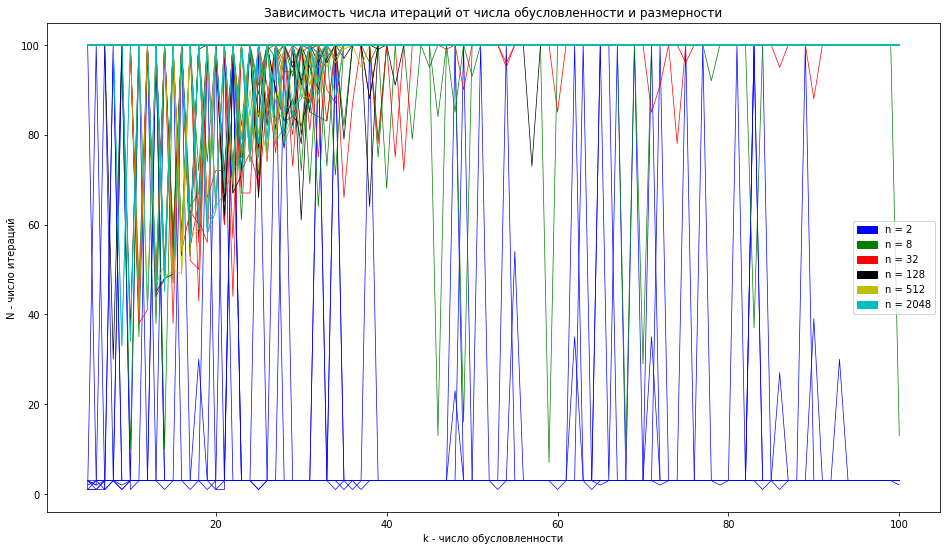

In [50]:
colors = ['b', 'g', 'r', 'k', 'y', 'c']

for i in range(len(n_values)): 
    for j in range(n_lines):
        plt.plot(k_values, iterations_mas[i, :, j], color=colors[i], linewidth=0.7)

# Creating legend with color box
b_patch = mpatches.Patch(color='b', label='n = 2')
g_patch = mpatches.Patch(color='g', label='n = 8')
r_patch = mpatches.Patch(color='r', label='n = 32')
k_patch = mpatches.Patch(color='k', label='n = 128')
y_patch = mpatches.Patch(color='y', label='n = 512')
c_patch = mpatches.Patch(color='c', label='n = 2048')
plt.legend(handles=[b_patch, g_patch, r_patch, k_patch, y_patch, c_patch])

# Adding labels
plt.xlabel('k - число обусловленности')
plt.ylabel('N - число итераций')

plt.title('Зависимость числа итераций от числа обусловленности и размерности')
plt.show()

Во-первых, график естественно получился бы нагляднее, если бы я убрал максимальное количество итераций iter_max=100 и поставил большее число, однако время расчета было бы намного дольше (так как при данных значениях расчет занял 21 минуту).  
Однако и по этим данным можно выявить некоторые закономерности.  
Итак, ясно видно, что по мере увеличения размерности функции число итераций (при любых значениях k) расчет - этот вывод действительно верен, так как в данной работе квадратичные функции на каждой итерации у каждого семейства случайны. Данный факт хорошо видел, если посмотреть на то что по мере увеличения n, траектории итераций которые отвечают за большее n мажорируют в среднем траектории, у которых n меньше.  
Также видно, что по мере увеличения числа обусловленности k количество итераций увеличивается линейно (это видно по скоплению траекторий в левой верхней четверти графика).   

# Задание 4. Градиентный спуск на задаче логистической регрессии

В этом задании требуется выполнить градиентный спуск на задаче логистической регресии для двух датасетов (9а9, gisette и real-sim). Также необходимо построить кривые траекторий для каждого датасета и каждого метода поиска шага (константный, Вульфа и Армихо).

Импортируем метод для загрузки датасета, а также сделаем функцию

In [4]:
from sklearn.datasets import load_svmlight_file

In [5]:
def get_data(data_path):
    data = load_svmlight_file(data_path)
    return data[0], data[1]

## Датасет 1. 9a9

Считаем датасет и преобразуем в тип ndarray

In [9]:
X, y = get_data("/content/drive/MyDrive/optimization-methods/src/datasets/a9a.txt")
X = X.toarray()

Создадим объект оракула логистической регрессии, используя загруженный только что датасет

In [10]:
log_reg_oracle = create_log_reg_oracle(A=X, b=y, regcoef=y.size)

Зададим начальный x_0 для всех способов градиентного спуска.  
Так как в данном датасете X.max() = 1 и X.min() = 0. То возьмем рандомный x_0 с компонентами из отрезка [0, 1).

In [11]:
x_0 = np.random.rand(X.shape[1])

Теперь используя данного оракла создадим три объекта из класса GradientDescent для сравнения методов выбора шага

### Константный метод

In [29]:
gd_const = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Constant', c=0.00003))
history_const = gd_const.run()

Выведем немного информции от работы

In [30]:
print(history_const['func'])

[205662.160066484, 196129.60935243787, 187043.95054728226, 178374.42686789017, 170111.29345114855, 162226.66410978348, 154711.59000093173, 147540.7956519921, 140706.05616245547, 134184.4704259259, 127968.47193495592, 122037.31900451594, 116384.04390925987, 110989.86890733273, 105848.3708453061, 100942.55815045504, 96266.50294212575, 91804.83814294855, 87552.08631076907, 83494.35783060103, 79626.58492308945, 75936.22171565834, 72418.573004995, 69062.31504632143, 65863.09147868182, 62810.69007789967, 59901.06263993053, 57125.00786352661, 54478.757787919305, 51954.03053985672, 49547.313009409845, 47251.1595351482, 45062.28875945015, 42974.01554643124, 40983.269279809625, 39084.05651209752, 37273.49825740977, 35546.23014955872, 33899.54745148223, 32328.65793812471, 30831.01531360722, 29402.347708430567, 28040.25289253849, 26740.932254829324, 25502.11455886696, 24320.431619025403, 23193.731305760088, 22119.036904290566, 21094.304583482237, 20116.913671937593, 19184.918809039504, 18296.02314

In [31]:
# some data about method work
print("Final point: y = %f" % (history_const['func'][-1]))
print("Number of iterations: %d" % (len(history_const['time']) - 1))
print("Execution time: %f sec" % (history_const['time'][-1]))
print("Norm of last d_k: %f" % (history_const['grad_norm'][-1]))

Final point: y = 1790.325785
Number of iterations: 100
Execution time: 51.519955 sec
Norm of last d_k: 3753.395849


### Метод Вульфа

In [26]:
gd_wolfe = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Wolfe'))
history_wolfe = gd_wolfe.run()

Выведем информацию о работе метода

In [28]:
print(history_wolfe['func'])

[205662.160066484, 203061.51082877035, 200499.16377021614, 197963.81960835203, 195465.8040616926, 192994.1251923259, 190558.82581660931, 188149.21362579576, 185775.05563563766, 183425.95164496196, 181111.39979208456, 178821.2846507545, 176564.842231112, 174332.23473337578, 172132.44261922687, 169955.89874648003, 167811.33444278358, 165689.4464297483, 163598.723154273, 161530.11857864677, 159491.8843652026, 157475.22526019026, 155488.1620844019, 153522.14407355696, 151584.96700061625, 149668.31845443443, 147779.7748082806, 145911.25602199978, 144070.1245753914, 142248.52696746733, 140453.61715242226, 138677.7624831615, 136927.91362125412, 135196.65323109896, 133490.73378311662, 131802.9478500885, 130139.85468456113, 128494.45150038128, 126873.10918050999, 125269.02444492829, 123688.38453345018, 122124.58066632377, 120583.62104786184, 119059.08651853666, 117556.81073899395, 116070.55941255332, 114605.99603512205, 113157.06653507655, 111729.2685124424, 110316.72359944611, 108924.767661778

In [27]:
# some data about method work
print("Final point: y = %f" % (history_wolfe['func'][-1]))
print("Number of iterations: %d" % (len(history_wolfe['time']) - 1))
print("Execution time: %f sec" % (history_wolfe['time'][-1]))
print("Norm of last d_k: %f" % (history_wolfe['grad_norm'][-1]))

Final point: y = 57695.440121
Number of iterations: 100
Execution time: 169.283400 sec
Norm of last d_k: 116864.342468


### Метод Армихо

In [32]:
gd_armijo = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Armijo'))
history_armijo = gd_armijo.run()

/content/drive/My Drive/optimization-methods/src/oracles.py:80: RuntimeWarning: overflow encountered in exp
  return np.average(np.log(1 + np.exp(-np.multiply(self.b, np.transpose(self.matvec_Ax(x)))))) + np.linalg.norm(x) * self.regcoef


Выведем информацию о работе метода

In [35]:
print(history_armijo['func'])

[205662.160066484, 203061.51082877035, 200499.16377021614, 197963.81960835203, 195465.8040616926, 192994.1251923259, 190558.82581660931, 188149.21362579576, 185775.05563563766, 183425.95164496196, 181111.39979208456, 178821.2846507545, 176564.842231112, 174332.23473337578, 172132.44261922687, 169955.89874648003, 167811.33444278358, 165689.4464297483, 163598.723154273, 161530.11857864677, 159491.8843652026, 157475.22526019026, 155488.1620844019, 153522.14407355696, 151584.96700061625, 149668.31845443443, 147779.7748082806, 145911.25602199978, 144070.1245753914, 142248.52696746733, 140453.61715242226, 138677.7624831615, 136927.91362125412, 135196.65323109896, 133490.73378311662, 131802.9478500885, 130139.85468456113, 128494.45150038128, 126873.10918050999, 125269.02444492829, 123688.38453345018, 122124.58066632377, 120583.62104786184, 119059.08651853666, 117556.81073899395, 116070.55941255332, 114605.99603512205, 113157.06653507655, 111729.2685124424, 110316.72359944611, 108924.767661778

In [36]:
# some data about method work
print("Final point: y = %f" % (history_armijo['func'][-1]))
print("Number of iterations: %d" % (len(history_armijo['time']) - 1))
print("Execution time: %f sec" % (history_armijo['time'][-1]))
print("Norm of last d_k: %f" % (history_armijo['grad_norm'][-1]))

Final point: y = 57695.440121
Number of iterations: 100
Execution time: 110.413111 sec
Norm of last d_k: 116864.342468


### Сравнение, графики и выводы

Приведем графики зависимости значения функции от метода выбора шара, по этим показателям сделаем вывод про эффективность методов

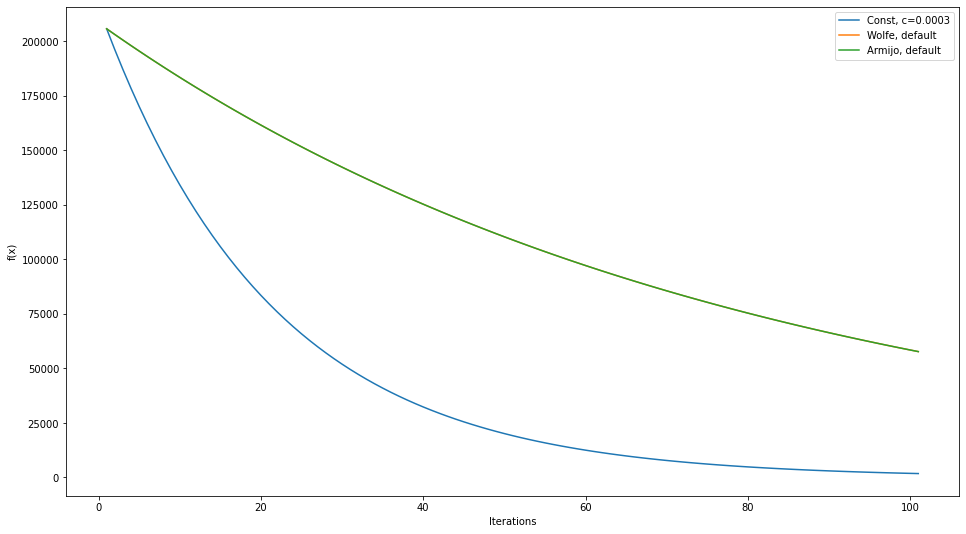

In [41]:
iterations = np.arange(1, 102)
plt.plot(iterations, history_const['func'], label="Const, c=0.0003")
plt.plot(iterations, history_wolfe['func'], label="Wolfe, default")
plt.plot(iterations, history_armijo['func'], label="Armijo, default")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('f(x)')
plt.show()

Видно, что методы Армихо и Вульфа сошлись - это произошло из-за того, чтобы когда мы используем метод Вульфа, то используем стороннюю библиотеку, и используемый метод может вернуть None в определенных случаях и тогда мы переходим к методу Армихо. Следовательно на большинстве итераций (если вообще не на всех) у нас происходил данный переход.  
Итак, можем сравнть лишь метод Армихо и константный метод.  
Удачно подобранная константа *c=0.00003* имеет довольно хорошую скорость поиска минимума функции ошибки логистической регрессии по сравнению с методом Армихо.  
На 100 итерациях результат такой, однако в дальнейшем (при увеличении числа итераций) метод Армихо может показать результат лучше (также если подобрать определенные параметры метода - результат может быть другим).  


Итак, попробуем увеличить число итераций, а также поменять параметры методов Армихо и Вульфа.

In [44]:
gd_const = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Constant', c=0.00003))
gd_armijo = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Armijo',c1=0.00003, alpha_0=0.05))
gd_wolfe = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Wolfe',c1=0.00003, c2=0.9, alpha_0=0.05))

history_const = gd_const.run(max_iter=200)
history_wolfe = gd_wolfe.run(max_iter=200)
history_armijo = gd_armijo.run(max_iter=200)

/content/drive/My Drive/optimization-methods/src/oracles.py:80: RuntimeWarning: overflow encountered in exp
  return np.average(np.log(1 + np.exp(-np.multiply(self.b, np.transpose(self.matvec_Ax(x)))))) + np.linalg.norm(x) * self.regcoef


In [51]:
# some info about methods works
print("Constant method")
print("Final point: y = %f" % (history_const['func'][-1]))
print("Number of iterations: %d" % (len(history_const['time']) - 1))
print('\n')
print("Wolfe method")
print("Final point: y = %f" % (history_wolfe['func'][-1]))
print("Number of iterations: %d" % (len(history_wolfe['time']) - 1))
print('\n')
print("Armijo method")
print("Final point: y = %f" % (history_armijo['func'][-1]))
print("Number of iterations: %d" % (len(history_armijo['time']) - 1))

Constant method
Final point: y = 16.153235
Number of iterations: 200


Wolfe method
Final point: y = 1.041421
Number of iterations: 8


Armijo method
Final point: y = 2.464946
Number of iterations: 22


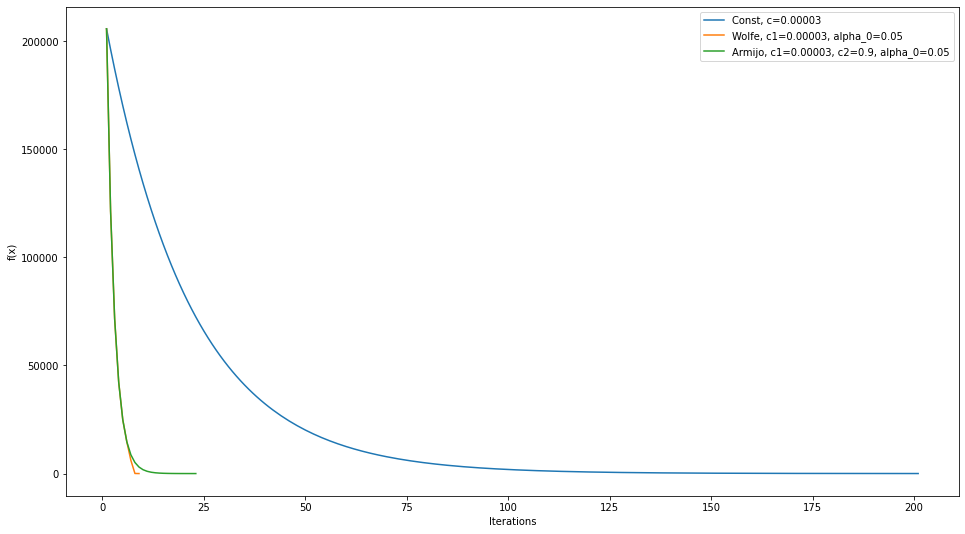

In [50]:
iterations = np.arange(1, 202)
iterations_w = np.arange(1, 10)
iterations_a = np.arange(1, 24)
plt.plot(iterations, history_const['func'], label="Const, c=0.00003")
plt.plot(iterations_w, history_wolfe['func'], label="Wolfe, c1=0.00003, alpha_0=0.05")
plt.plot(iterations_a, history_armijo['func'], label="Armijo, c1=0.00003, c2=0.9, alpha_0=0.05")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('f(x)')
plt.show()

При правильно подобранных гипер-параметрах наблюдаем совершенно другую картину.  
А именно, метод Вульфа справился с задачей минимизации с указанной точностью всего лишь за 8 итераций.  
Метод Армихо дает результат немного хуже (22 итерации), однако все равно существенно быстрее константного метода.  
Отдельно стоит указать на высокую точность работы алгоритмов с переменным шагом (Армихо и Вульфа) по сравнению с константным методов.  
Итак, данная работа подтверждает то, что качественно подобранные гипер-параметры модели могут существенно уменьшим вычислительные и временные затраты.

## Датасет 2. real-sim

Прочитаем датасет

In [52]:
X, y = get_data("/content/drive/MyDrive/optimization-methods/src/datasets/real-sim")
X = X.toarray()

In [54]:
log_reg_oracle = create_log_reg_oracle(A=X, b=y, regcoef=y.size)

Зададим начальный x_0 для всех способов градиентного спуска.  
Так как в данном датасете X.max() = 1 и X.min() = 0. То возьмем рандомный x_0 с компонентами из отрезка [0, 1).

In [57]:
x_0 = np.random.rand(X.shape[1])

Теперь используя данного оракла создадим три объекта из класса GradientDescent для сравнения методов выбора шага

### Константный метод

In [ ]:
gd_const = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Constant', c=1))
history_const = gd_const.run()

# ***ВАЖНО***
Из-за большого размера выборок real-sim и gisette-scale, а именно 72.309 объектов размерности 20.958 и 7.000 объектов размерности 5.000 соответственно проводить расчеты мне не удавалось (не хватает вычислительной мощности, а также возможно не хорошо оптимизированный вычислительный код).  
Поэтому проанализировать работу градиентного метода при различных методах выбора шага не получится на данных выборках.  
Однако я думаю, что будет уместным экстраполировать все выводы, которые были даны после анализа на первой выборке (a9a) и сюда.  
Ниже предоставлен код, который необходим был для анаиза второй и третьей выборок (его можно запустить на более мощных ЭВМ).

Выведем информацию о работе метода

In [ ]:
print(history_const['func'])

In [ ]:
# some data about method work
print("Final point: y = %f" % (history_const['func'][-1]))
print("Number of iterations: %d" % (len(history_const['time']) - 1))
print("Execution time: %f sec" % (history_const['time'][-1]))
print("Norm of last d_k: %f" % (history_const['grad_norm'][-1]))

### Метод Вульфа

In [ ]:
gd_wolfe = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Wolfe'))
history_wolfe = gd_wolfe.run()

Выведем информацию о работе метода

In [ ]:
print(history_wolf['func'])

In [ ]:
# some data about method work
print("Final point: y = %f" % (history_wolfe['func'][-1]))
print("Number of iterations: %d" % (len(history_wolfe['time']) - 1))
print("Execution time: %f sec" % (history_wolfe['time'][-1]))
print("Norm of last d_k: %f" % (history_wolfe['grad_norm'][-1]))

### Метод Армихо

In [ ]:
gd_armijo = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Armijo'))
history_armijo = gd_armijo.run()

Выведем информацию о работе метода

In [ ]:
print(history_armijo['func'])

In [ ]:
# some data about method work
print("Final point: y = %f" % (history_armijo['func'][-1]))
print("Number of iterations: %d" % (len(history_armijo['time']) - 1))
print("Execution time: %f sec" % (history_armijo['time'][-1]))
print("Norm of last d_k: %f" % (history_armijo['grad_norm'][-1]))

### Сравнение методов

Приведем графики для сравнения методов выбора шага

In [ ]:
iterations = np.arange(1, 102)
plt.plot(iterations, history_const['func'], label="Const")
plt.plot(iterations, history_wolfe['func'], label="Wolfe")
plt.plot(iterations, history_armijo['func'], label="Armijo")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('f(x)')
plt.show()

## Датасет 3. gisette_scale

Прочитаем датасет

In [55]:
X, y = get_data("/content/drive/MyDrive/optimization-methods/src/datasets/gisette_scale")
X = X.toarray()

Создадим объект оракула логистической регрессии, используя загруженный только что датасет

In [60]:
log_reg_oracle = create_log_reg_oracle(A=X, b=y, regcoef=y.size)

Зададим начальный x_0 для всех способов градиентного спуска.  
Так как в данном датасете X.max() = 1 и X.min() = -1. То возьмем рандомный x_0 с компонентами из отрезка [0, 1).

In [67]:
x_0 = np.random.rand(X.shape[1])

Теперь используя данного оракла создадим три объекта из класса GradientDescent для сравнения методов выбора шага

### Константный метод

In [ ]:
gd_const = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Constant', c=0.00003))
history_const = gd_const.run()

Выведем немного информции от работы

In [ ]:
print(history_const['func'])

[205662.160066484, 196129.60935243787, 187043.95054728226, 178374.42686789017, 170111.29345114855, 162226.66410978348, 154711.59000093173, 147540.7956519921, 140706.05616245547, 134184.4704259259, 127968.47193495592, 122037.31900451594, 116384.04390925987, 110989.86890733273, 105848.3708453061, 100942.55815045504, 96266.50294212575, 91804.83814294855, 87552.08631076907, 83494.35783060103, 79626.58492308945, 75936.22171565834, 72418.573004995, 69062.31504632143, 65863.09147868182, 62810.69007789967, 59901.06263993053, 57125.00786352661, 54478.757787919305, 51954.03053985672, 49547.313009409845, 47251.1595351482, 45062.28875945015, 42974.01554643124, 40983.269279809625, 39084.05651209752, 37273.49825740977, 35546.23014955872, 33899.54745148223, 32328.65793812471, 30831.01531360722, 29402.347708430567, 28040.25289253849, 26740.932254829324, 25502.11455886696, 24320.431619025403, 23193.731305760088, 22119.036904290566, 21094.304583482237, 20116.913671937593, 19184.918809039504, 18296.02314

In [ ]:
# some data about method work
print("Final point: y = %f" % (history_const['func'][-1]))
print("Number of iterations: %d" % (len(history_const['time']) - 1))
print("Execution time: %f sec" % (history_const['time'][-1]))
print("Norm of last d_k: %f" % (history_const['grad_norm'][-1]))

Final point: y = 1790.325785
Number of iterations: 100
Execution time: 51.519955 sec
Norm of last d_k: 3753.395849


### Метод Вульфа

In [ ]:
gd_wolfe = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Wolfe'))
history_wolfe = gd_wolfe.run()

Выведем информацию о работе метода

In [ ]:
print(history_wolfe['func'])

[205662.160066484, 203061.51082877035, 200499.16377021614, 197963.81960835203, 195465.8040616926, 192994.1251923259, 190558.82581660931, 188149.21362579576, 185775.05563563766, 183425.95164496196, 181111.39979208456, 178821.2846507545, 176564.842231112, 174332.23473337578, 172132.44261922687, 169955.89874648003, 167811.33444278358, 165689.4464297483, 163598.723154273, 161530.11857864677, 159491.8843652026, 157475.22526019026, 155488.1620844019, 153522.14407355696, 151584.96700061625, 149668.31845443443, 147779.7748082806, 145911.25602199978, 144070.1245753914, 142248.52696746733, 140453.61715242226, 138677.7624831615, 136927.91362125412, 135196.65323109896, 133490.73378311662, 131802.9478500885, 130139.85468456113, 128494.45150038128, 126873.10918050999, 125269.02444492829, 123688.38453345018, 122124.58066632377, 120583.62104786184, 119059.08651853666, 117556.81073899395, 116070.55941255332, 114605.99603512205, 113157.06653507655, 111729.2685124424, 110316.72359944611, 108924.767661778

In [ ]:
# some data about method work
print("Final point: y = %f" % (history_wolfe['func'][-1]))
print("Number of iterations: %d" % (len(history_wolfe['time']) - 1))
print("Execution time: %f sec" % (history_wolfe['time'][-1]))
print("Norm of last d_k: %f" % (history_wolfe['grad_norm'][-1]))

Final point: y = 57695.440121
Number of iterations: 100
Execution time: 169.283400 sec
Norm of last d_k: 116864.342468


### Метод Армихо

In [ ]:
gd_armijo = GradientDescent(log_reg_oracle, x_0, 1e-10, line_search_options=dict(method='Armijo'))
history_armijo = gd_armijo.run()

/content/drive/My Drive/optimization-methods/src/oracles.py:80: RuntimeWarning: overflow encountered in exp
  return np.average(np.log(1 + np.exp(-np.multiply(self.b, np.transpose(self.matvec_Ax(x)))))) + np.linalg.norm(x) * self.regcoef


Выведем информацию о работе метода

In [ ]:
print(history_armijo['func'])

[205662.160066484, 203061.51082877035, 200499.16377021614, 197963.81960835203, 195465.8040616926, 192994.1251923259, 190558.82581660931, 188149.21362579576, 185775.05563563766, 183425.95164496196, 181111.39979208456, 178821.2846507545, 176564.842231112, 174332.23473337578, 172132.44261922687, 169955.89874648003, 167811.33444278358, 165689.4464297483, 163598.723154273, 161530.11857864677, 159491.8843652026, 157475.22526019026, 155488.1620844019, 153522.14407355696, 151584.96700061625, 149668.31845443443, 147779.7748082806, 145911.25602199978, 144070.1245753914, 142248.52696746733, 140453.61715242226, 138677.7624831615, 136927.91362125412, 135196.65323109896, 133490.73378311662, 131802.9478500885, 130139.85468456113, 128494.45150038128, 126873.10918050999, 125269.02444492829, 123688.38453345018, 122124.58066632377, 120583.62104786184, 119059.08651853666, 117556.81073899395, 116070.55941255332, 114605.99603512205, 113157.06653507655, 111729.2685124424, 110316.72359944611, 108924.767661778

In [ ]:
# some data about method work
print("Final point: y = %f" % (history_armijo['func'][-1]))
print("Number of iterations: %d" % (len(history_armijo['time']) - 1))
print("Execution time: %f sec" % (history_armijo['time'][-1]))
print("Norm of last d_k: %f" % (history_armijo['grad_norm'][-1]))

Final point: y = 57695.440121
Number of iterations: 100
Execution time: 110.413111 sec
Norm of last d_k: 116864.342468


### Сравнение, графики и выводы

Приведем графики зависимости значения функции от метода выбора шара, по этим показателям сделаем вывод про эффективность методов

In [ ]:
iterations = np.arange(1, 102)
plt.plot(iterations, history_const['func'], label="Const")
plt.plot(iterations, history_wolfe['func'], label="Wolfe")
plt.plot(iterations, history_armijo['func'], label="Armijo")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('f(x)')
plt.show()